<a href="https://colab.research.google.com/github/baotram153/Reinforcement-Learning/blob/main/notebook/Eligibility_Trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gymnasium as gym

In [ ]:
def compute_RMS (true_values, estimated_values):
    len = true_values.shape[0]
    return 1 / np.sqrt(len) * np.linalg.norm(true_values - estimated_values)

## Off-line $\lambda$ return algorithm

### 19-state random walk environment

In [ ]:
class RandomWalkEnvironemnt:
    def __init__(self) -> None:
        self.n_states = 21  # index 0 -> 20
        self.start_state = 10
        self.terminal_states = [0, 20]  # reward at 0 is -1, at 20 is 1
        self.action_space = [-1, 1]
        self.n_actions = 2

    def get_action(self):
        return np.random.choice(self.action_space)

    def get_reward (self, state):
        if (state == 0): return -1
        elif (state == self.n_states-1): return 1
        else: return 0

    def step (self, old_state):
        new_state = max(0, min(self.get_action() + old_state, self.n_states - 1))
        if (new_state in self.terminal_states):
            terminated = True
        else: terminated = False
        return new_state, terminated

### Value function class to calculate Lambda return and DP state value

In [ ]:
class ValueFunction:    # gamma = 1
    def __init__(self, Lambda = 1, alpha = 0.01, gamma = 1) -> None:
        self.trajectory = []
        self.n_states = 0
        self.Lambda = Lambda
        self.params = np.zeros(21)
        self.alpha = alpha
        self.gamma = gamma

    def reset(self):
        self.trajectory = []
        self.n_states = 0

    def update (self, state, delta):
        self.params[state] += self.alpha*delta

    def update_DP (self, state, new_state_value):
        self.params[state] = new_state_value

    def get_value (self, state):
        if (state == 0 or state == 20): return 0
        else: return self.params[state]

    def update_trajectory (self, state):
        self.trajectory.append(state)
        self.n_states += 1

    def get_lambda_return (self, state_idx, env, truncate = False, horizon = -1):
        lambda_return = 0
        if (truncate == False):     # get lambda return to terminal state
            horizon = self.n_states - 1 - state_idx
        for i in range(horizon - 1):
            lambda_return += self.Lambda**(i)*self.get_n_step_TD_return (state_idx, i + 1, env)
        if (state_idx == (self.n_states - 2)):
            lambda_return = self.get_n_step_TD_return(state_idx, horizon, env)
        else:
            lambda_return = (1 - self.Lambda)*lambda_return + self.Lambda**(horizon - 1)*self.get_n_step_TD_return(state_idx, horizon, env)
        return lambda_return

    def get_n_step_TD_return (self, state_idx, n, env):
        if ((state_idx + n) == (self.n_states - 1)):
            return env.get_reward(self.trajectory[-1])
        else:
            return self.get_value(self.trajectory[state_idx + n])

### Calculate true state values using DP

In [ ]:
def dynamic_programming (n_eps, env, value_func):
    for ep in range(n_eps):
        for state in range(1, env.n_states - 1):
            new_state_value = 0
            for action in env.action_space:
                new_state = max(0, min(state + action, env.n_states - 1))
                if (new_state in env.terminal_states):
                    new_state_value += 1/env.n_actions*env.get_reward(new_state)
                else:
                    new_state_value += 1/env.n_actions*value_func.get_value(new_state)
            value_func.update_DP (state, new_state_value)
    return value_func.params

### Calculate estimated state value using Off-line $\lambda$ return algorithm

In [ ]:
def off_line_lambda_return (n_eps, env, value_func, return_RMS = False, true_values = []):
    RMS_vector = []
    for ep in range(n_eps):
        value_func.reset()
        value_func.update_trajectory (env.start_state)
        while True:
            new_state, terminated = env.step (value_func.trajectory[-1])
            value_func.update_trajectory(new_state)
            if (terminated):
                break
        for state_idx in range(value_func.n_states - 1):
            lambda_return = value_func.get_lambda_return(state_idx, env)
            delta = lambda_return - value_func.get_value(value_func.trajectory[state_idx])
            value_func.update(value_func.trajectory[state_idx], delta)
        if (return_RMS == True): RMS_vector.append(compute_RMS(true_values, value_func.params))
    if (return_RMS == True):
        # print(value_func.params)
        return RMS_vector
    else: return value_func.params

### Experiments

In [ ]:
def run_experiment (algorithm, value_func, n_eps, n_runs, alpha, Lambda, true_values) :
    RMS_vectors = []
    for _ in range(n_runs):
        RMS_vector = algorithm(n_eps= n_eps, env= RandomWalkEnvironemnt(), value_func= value_func(Lambda=Lambda, alpha=alpha), return_RMS= True, true_values= true_values)
        RMS_vectors.append(RMS_vector)
    mean_RMS_vector = np.mean(RMS_vectors, axis = 0)
    return np.average(mean_RMS_vector)

In [ ]:
def graphing (algorithm, value_func, n_eps, n_runs, Lambdas, alphas):
    y = np.array([np.zeros(len(alphas)) for _ in range(len(Lambdas))])
    for Lambda_idx, Lambda in enumerate(Lambdas):
        print(f"Lambda = {Lambda}")
        for alpha_idx, alpha in enumerate(alphas):
            y[Lambda_idx][alpha_idx] = run_experiment(algorithm, value_func, n_eps, n_runs, alpha, Lambda, true_values)

    for i in range(y.shape[0]):
        plt.plot(alphas, y[i])
    plt.axis([0, 1, 0.2, 0.6])
    plt.show()

In [ ]:
true_values = dynamic_programming(n_eps=500, env=RandomWalkEnvironemnt(), value_func=ValueFunction())
print(true_values)

[ 0.00000000e+00 -9.00000104e-01 -8.00000203e-01 -7.00000295e-01
 -6.00000377e-01 -5.00000448e-01 -4.00000506e-01 -3.00000551e-01
 -2.00000580e-01 -1.00000595e-01 -5.95347270e-07  9.99994192e-02
  1.99999448e-01  2.99999489e-01  3.99999542e-01  4.99999604e-01
  5.99999675e-01  6.99999752e-01  7.99999833e-01  8.99999917e-01
  0.00000000e+00]


lambda = 0
lambda = 0.4
lambda = 0.8
lambda = 0.9
lambda = 0.95
lambda = 0.975
lambda = 0.99
lambda = 1


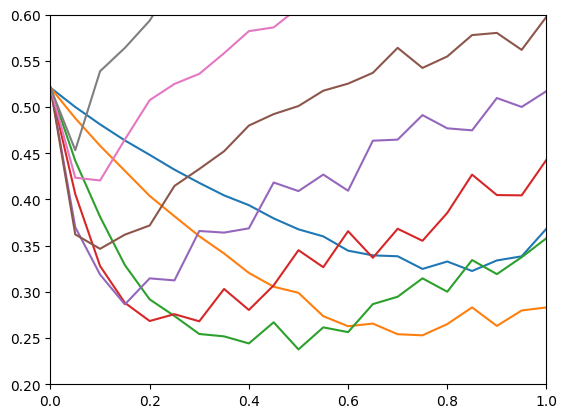

In [ ]:
n_eps = 10
n_runs = 20
Lambdas = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = np.linspace(0, 1, 21)
graphing (off_line_lambda_return, ValueFunction, n_eps, n_runs, Lambdas, alphas)

## TD ($\lambda$)

### Value function class with Accumulating Traces

In [ ]:
class ValueFunctionWithAccumulatingTrace (ValueFunction):
    def __init__(self, Lambda=0.8, alpha=0.4, gamma=1) -> None:
        super().__init__(Lambda, alpha, gamma)
        self.trace_vector = np.zeros(21)

    def reset_trace_vector(self):
        self.trace_vector = np.zeros(21)

    def update_trace_vector (self, state):
        self.trace_vector = self.Lambda*self.gamma*self.trace_vector
        self.trace_vector[state] += 1

    def update (self, delta):
        self.params = self.params + self.alpha*delta*self.trace_vector

### Calculate estimated state value using TD($\lambda$)

In [ ]:
def semi_gradient_TD_lambda (n_eps, env, value_func, return_RMS = False, true_values = []):
    RMS_vector = []
    for ep in range (n_eps):
        old_state = env.start_state
        value_func.reset_trace_vector()
        while True:
            new_state, terminated = env.step(old_state)
            value_func.update_trace_vector(old_state)
            # print(f"trace vector: {value_func.trace_vector}")
            reward = env.get_reward(new_state)
            delta = reward + value_func.gamma*value_func.get_value(new_state) - value_func.get_value(old_state)
            value_func.update (delta)
            old_state = new_state
            if (terminated): break
        if (return_RMS):
            RMS_vector.append(compute_RMS(true_values=true_values, estimated_values=value_func.params))
    if (return_RMS):
        return RMS_vector
    else:
        return value_func.params

### Experiment

Lambda = 0
Lambda = 0.4
Lambda = 0.8
Lambda = 0.9
Lambda = 0.95
Lambda = 0.975
Lambda = 0.99


<ipython-input-21-6018ac0631e3>:14: RuntimeWarning: overflow encountered in multiply
  self.params = self.params + self.alpha*delta*self.trace_vector
<ipython-input-21-6018ac0631e3>:14: RuntimeWarning: invalid value encountered in multiply
  self.params = self.params + self.alpha*delta*self.trace_vector
<ipython-input-21-6018ac0631e3>:14: RuntimeWarning: invalid value encountered in add
  self.params = self.params + self.alpha*delta*self.trace_vector


Lambda = 1


<ipython-input-22-8129828ba21c>:11: RuntimeWarning: invalid value encountered in double_scalars
  delta = reward + value_func.gamma*value_func.get_value(new_state) - value_func.get_value(old_state)
<ipython-input-21-6018ac0631e3>:14: RuntimeWarning: overflow encountered in add
  self.params = self.params + self.alpha*delta*self.trace_vector


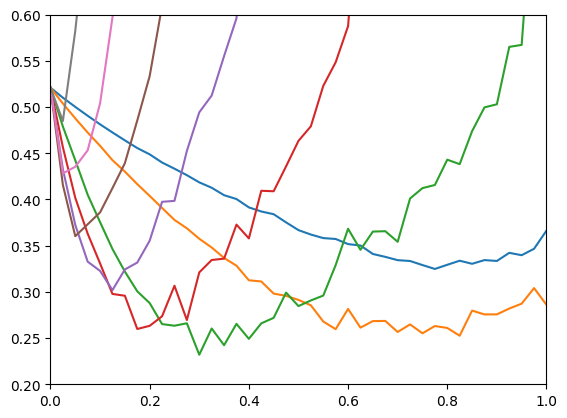

In [ ]:
n_eps = 10
n_runs = 20
Lambdas = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = np.linspace(0, 1, 41)
graphing (semi_gradient_TD_lambda, ValueFunctionWithAccumulatingTrace, n_eps, n_runs, Lambdas, alphas)

## True online TD ($\lambda$)

### Value function class with Dutch Traces

In [ ]:
class ValueFunctionWithDutchTrace (ValueFunction):
    def __init__(self, Lambda=1, alpha=0.01, gamma=1) -> None:
        super().__init__(Lambda, alpha, gamma)
        self.trace_vector = np.zeros(21)

    def reset_trace_vector(self):
        self.trace_vector = np.zeros(21)

    def update_trace_vector  (self, state):
        self.trace_vector *= self.gamma*self.Lambda
        self.trace_vector[state] += (1 - self.alpha*self.gamma*self.Lambda*self.trace_vector[state])

    def update (self, delta, old_state, old_state_old_value, old_state_value):
        self.params += self.alpha*(delta + old_state_value - old_state_old_value)*self.trace_vector
        self.params[old_state] -= self.alpha*(old_state_value - old_state_old_value)

### Calculate estimated state value using True online TD($\lambda$)

In [ ]:
def true_online_TD_lambda (n_eps, env, value_func, return_RMS = False, true_values = []):
    RMS_vector = []
    for ep in range(n_eps):
        value_func.reset_trace_vector()
        old_state_old_value = 0
        old_state = env.start_state
        while True:
            new_state, terminated = env.step(old_state)
            old_state_value = value_func.get_value(old_state)
            new_state_value = value_func.get_value(new_state)
            reward = env.get_reward(new_state)
            delta = reward + value_func.gamma*new_state_value - old_state_value
            value_func.update_trace_vector(old_state)
            value_func.update(delta, old_state, old_state_old_value, old_state_value)
            old_state_old_value = new_state_value
            old_state = new_state
            if (terminated): break
        if (return_RMS):
            RMS_vector.append(compute_RMS(true_values, value_func.params))
    if (return_RMS):
        return RMS_vector
    else:
        return value_func.params

### Experiment

lambda = 0
lambda = 0.4
lambda = 0.8
lambda = 0.9
lambda = 0.95
lambda = 0.975
lambda = 0.99
lambda = 1


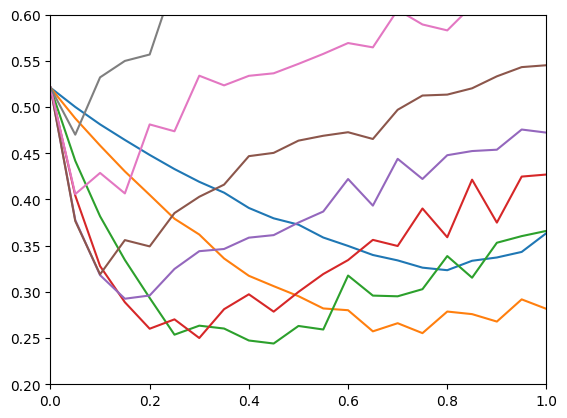

In [ ]:
n_eps = 10
n_runs = 20
Lambdas = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = np.linspace(0, 1, 21)
graphing (true_online_TD_lambda, ValueFunctionWithDutchTrace, n_eps, n_runs, Lambdas, alphas)

## Sarsa ($\lambda$)

### Mountain Car Agent

In [ ]:
class TilingWithDutchTrace (Tiling):
    def __init__(self, Lambda, n_tilings, n_tiles, state_size, max_size=4096) -> None:
        super().__init__(n_tilings, n_tiles, state_size, max_size)
        self.trace_vector = np.zeros(max_size)
        self.Lambda = Lambda

    def reset_trace_vector(self):
        self.trace_vector = np.zeros(self.max_size)

    def update_trace_vector (self, state_indices):
        self.trace_vector *= self.gamma*self.Lambda
        inner_prod = 0
        for idx in state_indices:
            inner_prod += self.trace_vector[idx]*self.params[idx]
        diff = 1 - self.alpha*self.gamma*self.Lambda*inner_prod
        for idx in state_indices:
            self.trace_vector[idx] += diff

    def update (self, state_indices, delta, old_state_action_old_value, old_state_action_value):
        self.params += self.alpha*(delta + old_state_action_value - old_state_action_old_value)*self.trace_vector
        diff = self.alpha*(old_state_action_value - old_state_action_old_value)
        for idx in state_indices:
            self.params[idx] -= diff

In [ ]:
"""From Control with Function Aproximation"""
class MountainCarAgent:
    def __init__    (
        self,
        value_func,
        alpha,
        gamma,
        epsilon
    ) -> None:
        self.alpha = alpha
        self.gamma = gamma
        self.value_func = value_func
        self.epsilon = epsilon

    def get_q_value (self, state, action):
        q_value = self.value_func.get_value(state, action)
        # if (q_value):
        #     return q_value
        # else:
        #     return 0    # Nontype
        return q_value

    def get_action  (self, state, env):     # 3 actions from 0->2 {accelerate to left, not accelerate, accelerate to right}
        if (np.random.rand() < self.epsilon):
            action = env.action_space.sample()
        else:
            action_values = []
            for action in range(env.action_space.n):
                action_values.append(self.get_q_value(state, action))
            if (np.array(action_values).all() == 0): action = env.action_space.sample()
            else:
                action = np.argmax(action_values)
        return action


    def update(self, state, action,error):
        self.value_func.update(state, action, error, self.alpha)

### Find $q_*$ using Sarsa ($\lambda$) algorithm

## True online Sarsa ($\lambda$)

In [ ]:
def true_online_Sarsa_lambda (n_eps, env, agent):   # Mountain Car environment
    for ep in range(n_eps):
        old_state, info = env.reset()
        old_action = agent.get_action(old_state)
        old_indices = agent.value_func.get_indices(old_state, old_action)
        agent.value_func.reset_trace_vector()
        old_state_action_old_value = 0
        while True:
            new_state, reward, terminated, truncated, info = env.step(old_action)
            new_action = agent.get_action(new_state)
            new_indices = agent.value_func.get_indices(new_state, new_action)
            old_state_action_value = agent.get_q_value(old_state, old_action)
            new_state_action_value = agent.get_q_value(new_state, new_action)
            delta = reward + agent.gamma*new_state_action_value - old_state_action_value
            agent.value_func.update_trace_vector(old_indices)
            agent.update(old_indices, delta, old_state_action_old_value, old_state_action_value)
            old_state_action_old_value = new_state_action_value
            old_indices = new_indices
            old_action = new_action
            if (terminated):
                break
    return agent.value_func.params